In [1]:
# modified from
# https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

[Learn the Basics](intro.html) \|\| **Quickstart** \|\|
[Tensors](tensorqs_tutorial.html) \|\| [Datasets &
DataLoaders](data_tutorial.html) \|\|
[Transforms](transforms_tutorial.html) \|\| [Build
Model](buildmodel_tutorial.html) \|\|
[Autograd](autogradqs_tutorial.html) \|\|
[Optimization](optimization_tutorial.html) \|\| [Save & Load
Model](saveloadrun_tutorial.html)

Quickstart
==========

This section runs through the API for common tasks in machine learning.
Refer to the links in each section to dive deeper.

Working with data
-----------------

PyTorch has two [primitives to work with
data](https://pytorch.org/docs/stable/data.html):
`torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. `Dataset`
stores the samples and their corresponding labels, and `DataLoader`
wraps an iterable around the `Dataset`.


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

PyTorch offers domain-specific libraries such as
[TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and
[TorchAudio](https://pytorch.org/audio/stable/index.html), all of which
include datasets. For this tutorial, we will be using a TorchVision
dataset.

The `torchvision.datasets` module contains `Dataset` objects for many
real-world vision data like CIFAR, COCO ([full list
here](https://pytorch.org/vision/stable/datasets.html)). In this
tutorial, we use the FashionMNIST dataset. Every TorchVision `Dataset`
includes two arguments: `transform` and `target_transform` to modify the
samples and labels respectively.


In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the `Dataset` as an argument to `DataLoader`. This wraps an
iterable over our dataset, and supports automatic batching, sampling,
shuffling and multiprocess data loading. Here we define a batch size of
64, i.e. each element in the dataloader iterable will return a batch of
64 features and labels.


In [41]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

print(60000/64)
print(len(training_data))
print(len(test_data))
print(len(train_dataloader))
print(len(test_dataloader))

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
937.5
60000
10000
938
157


Read more about [loading data in PyTorch](data_tutorial.html).


------------------------------------------------------------------------


Creating Models
===============

To define a neural network in PyTorch, we create a class that inherits
from
[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
We define the layers of the network in the `__init__` function and
specify how data will pass through the network in the `forward`
function. To accelerate operations in the neural network, we move it to
the GPU or MPS if available.


In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [61]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


from LeNet import LeNetplus
model = LeNetplus()
model = model.to(device)
print(model)

LeNetplus(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=3, stride=2, padding=0, dilatio

In [62]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 9307786


Read more about [building neural networks in
PyTorch](buildmodel_tutorial.html).


------------------------------------------------------------------------


Optimizing the Model Parameters
===============================

To train a model, we need a [loss
function](https://pytorch.org/docs/stable/nn.html#loss-functions) and an
[optimizer](https://pytorch.org/docs/stable/optim.html).


In [63]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.01)

train_loss = []
train_acc = []
test_loss = []
test_acc = []

In a single training loop, the model makes predictions on the training
dataset (fed to it in batches), and backpropagates the prediction error
to adjust the model\'s parameters.


In [64]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    model.train()
    
    loss_sum, correct = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_sum += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        if batch % 500 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"train_loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    loss_sum /= num_batches
    correct /= size
    
    train_loss.append(loss_sum)
    train_acc.append(100*correct)

We also check the model\'s performance against the test dataset to
ensure it is learning.


In [65]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    correct /= size
    
    test_loss.append(loss)
    test_acc.append(100*correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {loss:>8f} \n")

The training process is conducted over several iterations (*epochs*).
During each epoch, the model learns parameters to make better
predictions. We print the model\'s accuracy and loss at each epoch;
we\'d like to see the accuracy increase and the loss decrease with every
epoch.


In [66]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
train_loss: 2.321192  [   64/60000]
train_loss: 0.500898  [32064/60000]
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.430812 

Epoch 2
-------------------------------
train_loss: 0.366302  [   64/60000]
train_loss: 0.471779  [32064/60000]
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.393019 

Epoch 3
-------------------------------
train_loss: 0.293010  [   64/60000]
train_loss: 0.521627  [32064/60000]
Test Error: 
 Accuracy: 87.0%, Avg loss: 0.386887 

Epoch 4
-------------------------------
train_loss: 0.243373  [   64/60000]
train_loss: 0.425921  [32064/60000]
Test Error: 
 Accuracy: 88.4%, Avg loss: 0.335931 

Epoch 5
-------------------------------
train_loss: 0.252719  [   64/60000]
train_loss: 0.352455  [32064/60000]
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.390648 

Epoch 6
-------------------------------
train_loss: 0.232026  [   64/60000]
train_loss: 0.382828  [32064/60000]
Test Error: 
 Accuracy: 89.2%, Avg loss: 0.312015 

Epoch 7
--------

In [67]:
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [68]:
train_acc

[80.635,
 86.30833333333334,
 87.74,
 88.645,
 89.17666666666668,
 89.37333333333333,
 89.76833333333335,
 90.08166666666668,
 90.15833333333333,
 90.21333333333334,
 90.27833333333334,
 90.39166666666667,
 90.41666666666667,
 90.54833333333333,
 90.63,
 90.59666666666666,
 90.68,
 90.72333333333333,
 90.73833333333333,
 90.92833333333333]

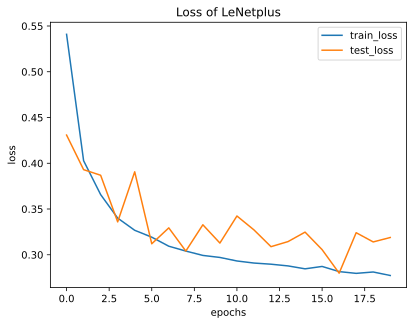

In [69]:
x = [i for i in range(epochs)]
train_loss = train_loss
fig1, ax1 = plt.subplots()
ax1.plot(x ,train_loss, label='train_loss')
ax1.plot(x ,test_loss, label='test_loss')
ax1.set(title=f'Loss of {model.__class__.__name__ }', xlabel='epochs', ylabel='loss' )
ax1.legend()

fig1.savefig(r'loss.svg')

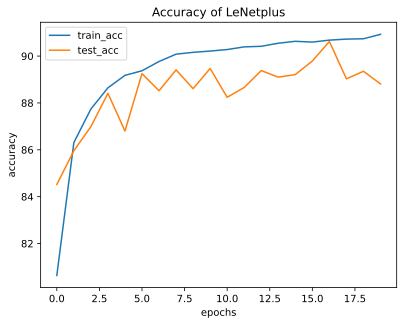

In [71]:
fig2, ax2 = plt.subplots()
ax2.plot(x ,train_acc, label='train_acc')
ax2.plot(x ,test_acc, label='test_acc')
ax2.set(title=f'Accuracy of {model.__class__.__name__ }', xlabel='epochs', ylabel='accuracy' )
ax2.legend()

Read more about [Training your model](optimization_tutorial.html).


------------------------------------------------------------------------


Saving Models
=============

A common way to save a model is to serialize the internal state
dictionary (containing the model parameters).


In [72]:
model_path = f"./models/{model.__class__.__name__ }.pth"
torch.save(model.state_dict(), model_path)
print(f"Saved PyTorch Model State to {model_path}")

Saved PyTorch Model State to ./models/LeNetplus.pth


Loading Models
==============

The process for loading a model includes re-creating the model structure
and loading the state dictionary into it.


In [73]:
model = LeNetplus().to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

This model can now be used to make predictions.


In [74]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x.unsqueeze(0))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


Read more about [Saving & Loading your
model](saveloadrun_tutorial.html).
